<a href="https://colab.research.google.com/github/Bingle-labake/deeplearn/blob/master/3/1/3_1_30_maxpooling_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134983 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
cd /content/drive/colab/3_1_30/

/content/drive/colab/3_1_30


## **最大池化层**

在此 notebook 中，我们将在 CNN 里添加最大池化层并可视化它的输出结果。

该 CNN 由一个卷积层+激活函数，然后是一个池化层和线性层（以形成期望的输出大小）组成。

![替代文字](http://p5.qhimg.com/t01d15d405eac019300.png)

###**导入图像**¶

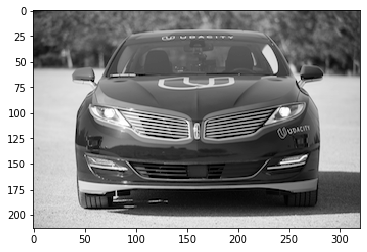

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Feel free to try out your own images here by changing img_path
# to a file path to another image on your computer!
img_path = 'data/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

###**定义和可视化过滤器**

In [5]:
import numpy as np

## TODO: Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [6]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


###**定义卷积层和池化层**
你已经知道如何定义卷积层，接下来是：


*   **池化层**


在下个单元格中，我们将初始化卷积层，使其包含所有已创建的过滤器。然后添加最大池化层（请参阅[此文档](https://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html)），卷积核大小是 2x2，所以在这一步之后，图像分辨率变小了！

最大池化层会减小输入的 x-y 大小，并仅保留最活跃的像素值。下面是一个示例 2x2 池化核，步长为 2，应用到了一小批灰阶像素值，使这批数据的大小缩小到 1/4。只有 2x2 中的最大像素值保留在新的池化输出中。

![替代文字](http://p6.qhimg.com/t01f90180c88b2316b2.png)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # defines the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        # define a pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


###**可视化每个过滤器的输出**

首先，我们将定义一个辅助函数 viz_layer，它接受特定的层级和过滤器数量（可选参数），并在图像穿过之后，显示该层级的输出。

In [0]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

我们看看在应用 ReLu 激活函数之前和之后卷积层的输出。

#####**ReLU 激活**

ReLU 函数将所有负像素值变成 0（黑色）。对于输入像素值 x，请查看下图中的方程。

![替代文字](http://p8.qhimg.com/t012f0041be968d1f90.png)


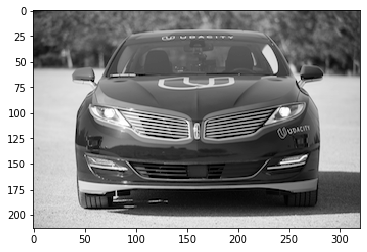

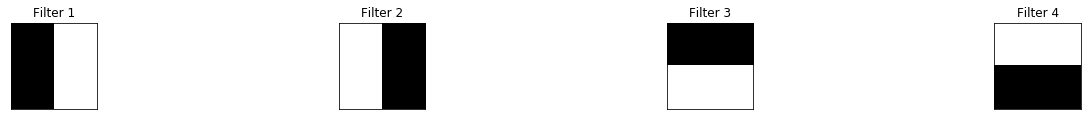

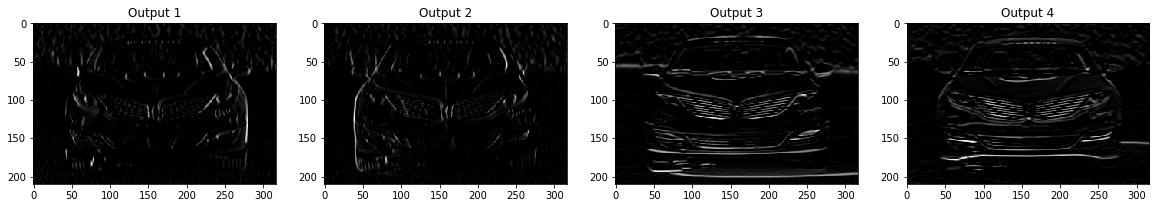

In [9]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(activated_layer)

###**可视化池化层的输出**
然后，查看池化层的输出。池化层将上图中的特征图当做输入，并以特定的池化系数降低这些特征图的维度，仅用给定核区域的最大值（最亮像素）构建新的更小图像。

请查看 x,y 轴上的值，看看图像的大小变化了多少。



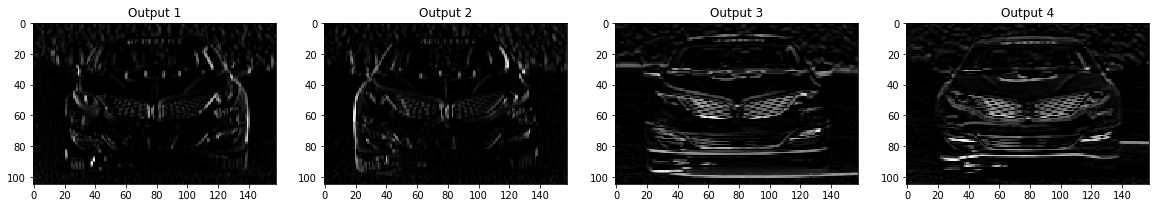

In [10]:
# visualize the output of the pooling layer
viz_layer(pooled_layer)